# Synchronous Advantage Actor-Critic (A2C)

We will be implementing the actor-critic method Synchronous Advantage Actor-Critic (A2C). A2C is a synchronous version of the asynchronous algorithm A3C.  We will adapt the actor-critic method by replacing the TD error value with the advantage value in the policy gradient update. The advantage function, $A^{\pi}$, following policy $\pi$ is defined by:
$$A^{\pi} = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$$
where $Q^{\pi}(s_t, a_t)$ is the action-value function following policy $\pi$ and $V^{\pi}(s_t)$ is the state-value function following policy $\pi$. The advantage function essentially measures the advantage gained (or lost) by taking the action $a_t$ in state $s_t$ over the average return of all immediate actions, and then following policy $\pi$ in the following states. We don't know the absolute value of the advantage, $A^{\pi}$, hence we need to find an advantage estimate, $\hat{A}$, as a substitute.

The TD error was shown in [1] to be an advantage estimate function itself, which makes the actor-critic method easy to alter by performing a drop-in replacement with other advantage functions such as GAE. GAE is a good alternative to the TD error, because it has lower bias at the cost of a minor increase in variance. GAE is defined by:
$$\hat{A}_{t}^{GAE} = \sum_{l=0}^{T}(\gamma \lambda)^{l}\delta_{t+l},$$ 
where $\delta_{t+l}$ is the TD error, $\gamma$ is the discount rate, $\lambda$ is the decay rate and $T$ is the final timestep, which can be $\infty$ if the episode is non-terminating. The bias-variance trade-off can be finetuned by altering the discount rate $\gamma$ and/or the decay rate $\lambda$. Larger discount/decay rates lead to higher variance and lower bias and lower discount/decay rates lead to lower variance and higher bias. 

The state-value function parameter update becomes:
$$w \leftarrow w + \alpha^{w}\nabla\hat{v}(S_t, w)\hat{A}_{t}^{GAE},$$
where $\alpha$ is the step-size or learning rate.

The policy function update now becomes:
$$\theta \leftarrow \theta + \alpha^{\theta} \nabla_\theta \log(\pi_\theta(a_t | s_t))\hat{A}_{t}^{GAE}.$$



For more information on A2C and Generalized Advantage Estimate algorithm, see the original GAE paper [1] [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438), the blog post [2] [Generalized Advantage Estimate: Maths and Code](https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737) and the original A3C paper [3] [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783).


In [128]:
import os
import gymnasium as gym
import numpy as np
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import jax
import flax.linen as nn
from jax import random
from jax import grad, value_and_grad
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [129]:
# Type of environment, options include:
# CartPole-v1
ENV_TYPE = "CartPole-v1"

# Save videos from training
SAVE_VIDEOS = True
VIDEOS_ROOT_DIR = './videos/a2c/'

In [130]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible states and actions
num_actions = env.action_space.n
obs_dims = env.observation_space.shape
obs_upper_bounds = env.observation_space.high
obs_lower_bounds = env.observation_space.low

## Create The Policy 

In [131]:
class _policy_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(64)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(num_actions)(x)
        return jax.nn.softmax(x)

# Create the model object
policy_fn = _policy_fn()
# Display the model details
dummy_x, _ = env.reset()
rng_key = random.PRNGKey(64)
print(policy_fn.tabulate(rng_key, dummy_x))


                               _policy_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module     ┃ inputs       ┃ outputs      ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _policy_fn │ float32[4]   │ float32[2]   │                         │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_0 │ Dense      │ float32[4]   │ float32[256] │ bias: float32[256]      │
│         │            │              │              │ kernel: float32[4,256]  │
│         │            │              │              │                         │
│         │            │              │              │ 1,280 (5.1 KB)          │
├─────────┼────────────┼──────────────┼──────────────┼─────────────────────────┤
│ Dense_1 │ Dense      │ float32[256] │ float32[64]  │ bias: float32[64]       │
│         │            │   

In [132]:
class _value_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = jax.nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Create the model object
value_fn = _value_fn()
# Display the model details
print(value_fn.tabulate(rng_key, dummy_x))


                              _value_fn Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs       ┃ outputs      ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ _value_fn │ float32[4]   │ float32[1]   │                        │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_0 │ Dense     │ float32[4]   │ float32[256] │ bias: float32[256]     │
│         │           │              │              │ kernel: float32[4,256] │
│         │           │              │              │                        │
│         │           │              │              │ 1,280 (5.1 KB)         │
├─────────┼───────────┼──────────────┼──────────────┼────────────────────────┤
│ Dense_1 │ Dense     │ float32[256] │ float32[1]   │ bias: float32[1]       │
│         │           │              │             

In [133]:
# code obtained from: https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737
def get_gae(
    gamma, lamda, value_old_states, value_new_states, rewards, done
):
    """
    Get generalized advantage estimate of a trajectory
    gamma: trajectory discount (scalar)
    lamda: exponential mean discount (scalar)
    value_old_states: value function result's with old_state input
    value_new_states: value function result's with new_state input
    rewards: agent rewards of taking actions in the environment
    done: flag list for end of episode
    """
    batch_size = len(done)

    advantage = np.zeros(batch_size + 1)

    for t in reversed(range(batch_size)):
        delta = rewards[t] + (gamma * value_new_states[t] * done[t]) - value_old_states[t]
        advantage[t] = delta + (gamma * lamda * advantage[t + 1] * done[t])

    return np.sum(advantage)

In [134]:
def policy_loss_fn(policy_variables, state, action, advantage):

    action_dist = policy_fn.apply(policy_variables, state)
    prob = action_dist[action]
    log_prob = jnp.log(prob)

    loss = -(advantage * log_prob)

    return loss 

In [135]:
def value_loss_fn(variables, state, advantage):
    value = value_fn.apply(variables, state)[0]
    loss = advantage * value
    return loss 

## Learn The Optimal Action-Value Function

In [136]:
# Number of episodes to train on
episodes = 51
# Sliding window for episode evaluation (needs to be less than episodes)
episode_window = 5
# Discount ratio
gamma = 0.99
trace_decay_rate = 0.8
# Step size
policy_alpha = 0.00007
value_alpha = 0.00007

policy_variables = policy_fn.init(rng_key, dummy_x)
policy_optimizer = optax.adam(learning_rate=policy_alpha)
policy_opt_state = policy_optimizer.init(policy_variables)

value_variables = value_fn.init(rng_key, dummy_x)
value_optimizer = optax.adam(learning_rate=value_alpha)
value_opt_state = value_optimizer.init(value_variables)

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )

for episode in range(1, episodes+1):
    terminated, truncated = False, False
    reward = 0

    value_old_states = []
    value_new_states = []
    rewards = []
    done = []

    state, info = env.reset()
    # Generate an episode following the policy
    while not (terminated or truncated):
        # Select the action following the parametrized policy
        action_dist = policy_fn.apply(policy_variables, state)
        action_dist = np.array(action_dist).astype(np.float64)
        # Divide by the total to ensure the values sum to one
        action_dist /= action_dist.sum()
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(int(action))
        rewards.append(reward)
        done.append(terminated or truncated)

        value = value_fn.apply(value_variables, state)[0]
        next_value = value_fn.apply(value_variables, next_state)[0]

        value_old_states.append(value)
        value_new_states.append(next_value)

        advantage = get_gae(gamma, trace_decay_rate, value_old_states, value_new_states, rewards, done)

        value_loss, value_grads = value_and_grad(value_loss_fn, argnums=0)(value_variables, state, advantage)
        value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_variables)
        value_variables = optax.apply_updates(value_variables, value_updates)        

        policy_loss, policy_grads = value_and_grad(policy_loss_fn, argnums=0)(policy_variables, state, action, advantage)
        policy_updates, policy_opt_state = policy_optimizer.update(policy_grads, policy_opt_state, policy_variables)
        policy_variables = optax.apply_updates(policy_variables, policy_updates)

        state = next_state
            

    if episode % episode_window == 0:
        print(f'Episode {episode} Average Returns: {np.mean(np.array(env.return_queue).flatten()[-episode_window:]) :.2f}')

Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-0.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-0.mp4


Episode 5 Average Returns: 34.40
Episode 10 Average Returns: 33.20
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-10.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-10.mp4


Episode 15 Average Returns: 23.00
Episode 20 Average Returns: 34.80
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-20.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-20.mp4


Episode 25 Average Returns: 53.00
Episode 30 Average Returns: 34.60
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-30.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-30.mp4


Episode 35 Average Returns: 48.80
Episode 40 Average Returns: 20.60
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-40.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-40.mp4


Episode 45 Average Returns: 52.80
Episode 50 Average Returns: 48.40
Moviepy - Building video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-50.mp4.
Moviepy - Writing video /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /home/ubuntu20/code/rl-tabular-algorithms/videos/a2c/CartPole-v1-episode-50.mp4


## Plot The Results

For cartpole rewards are assigned for the time spent in a non-terminal state. The episode length and rewards will be identical in this case.

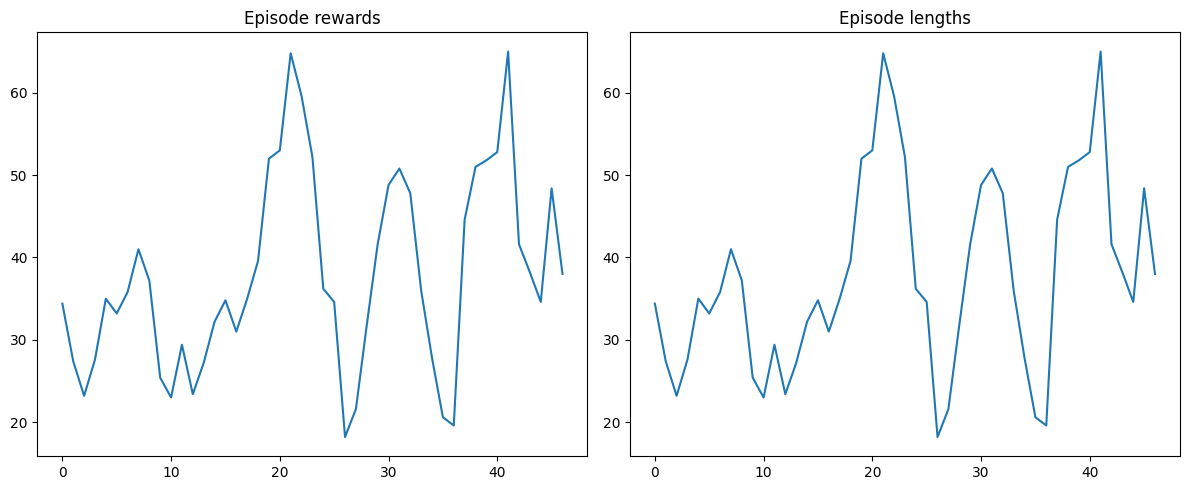

In [137]:
# Code used from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/#visualizing-the-training
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(episode_window), mode="valid"
    )
    / episode_window
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
plt.tight_layout()
plt.show()

## Training Episode Videos

### Episode 0

In [138]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episode 10

In [139]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 20

In [140]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [141]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [142]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

### Episode 50

In [143]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-50.mp4")